In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import MicroTools as micro
from MicroTools import plot_tools as pt
import MiniTools as mini
import param_scan

from importlib.resources import open_text


In [3]:
# settings for Fig. 1
TOTAL_RATE = False
INCLUDE_MB_LAST_BIN = False
STACKED = False
PLOT_FAMILY=False
colormap=cm.Blues
TEMP1_COLOR = 'deeppink'
TEMP2_COLOR = 'dodgerblue'

PATH_PLOTS = 'plots/event_rates/'

In [4]:
Weight_nue_flux = mini.apps.reweight_MC_to_nue_flux(
            param_scan.Etrue_nue, param_scan.Weight_nue, mode="fhc"
        )

MC_nue_bkg_intrinsic = np.dot(
                param_scan.fast_histogram(
                    param_scan.Etrue_nue, bins=param_scan.e_prod_e_int_bins, weights=Weight_nue_flux
                )[0],
                mini.apps.migration_matrix_official_bins_nue_11bins,
            )

In [5]:
def make_rate_plot(rates, params, name='3+1_osc'):
    fig, ax1 = pt.std_fig(figsize=(3.3*1.2,2*1.2))
    bins = param_scan.MB_Ereco_official_bins
    bin_w = np.diff(bins)
    bin_c = bins[:-1] + bin_w/2

    ######################################
    # MiniBooNE 
    if TOTAL_RATE:
        units= 1
        ax1.set_ylabel(r"Events")
    else:
        units = 1/micro.bin_width
        ax1.set_ylabel(r"Events/MeV")

    nue_data = np.genfromtxt(
        open_text(
            f"MiniTools.include.MB_data_release_2020.combined",
            f"miniboone_nuedata_lowe.txt",
        )
    )
    nue_tot_bkg = np.genfromtxt(
                open_text(
                    f"MiniTools.include.MB_data_release_2020.combined",
                    f"miniboone_nuebgr_lowe.txt",
                )
            )
    nue_bkg_midID = nue_tot_bkg - MC_nue_bkg_intrinsic

    # plot data
    pt.data_plot(ax1, 
            X=bin_c,
            Y=nue_data*units, 
            xerr=bin_w/2, 
            yerr=np.sqrt(nue_data)*units,
            zorder=3)


    ax1.hist(bins[:-1],
            bins=bins,
            weights=(nue_tot_bkg)*units,
            edgecolor='black',
            lw=0.5,
            ls=(1,(2,1)),
            label=r'unoscillated total bkg',
            histtype='step',
            zorder=1.6)
    ax1.hist(bins[:-1],
            bins=bins,
            weights=(nue_bkg_midID)*units,
            edgecolor='black',
            facecolor='lightgrey',
            lw=0.5,
            label=r'misID bkg',
            histtype='stepfilled',
            zorder=2)
    ax1.hist(bins[:-1],
            bins=bins,
            # weights=(nue_tot_bkg)*units,
            weights=rates['MC_nue_bkg_total_w_dis']*units,
            edgecolor='black',
            facecolor='peachpuff',
            lw=0.5,
            label=r'$\nu_e$ disappearance',
            histtype='stepfilled',
            zorder=1.6)
    ax1.hist(bins[:-1],
            bins=bins,
            weights=(rates['MC_nue_app'] + rates['MC_nue_bkg_total_w_dis'])*units,
            # weights=(rates_dic_osc['MC_nue_app'] + nue_tot_bkg)*units,
            edgecolor='black',
            facecolor='lightblue',
            lw=0.5,
            linestyle=(1,(3,0)),
            label=r'$\nu_\mu \to \nu_e$ appearance',
            histtype='stepfilled',
            zorder=1.5)



    ax1.legend(fontsize=8, markerfirst=False, ncol=1)
    ax1.annotate(text=r'MiniBooNE FHC 2020', xy=(0.0,1.025), xycoords='axes fraction', fontsize=9)
    ax1.annotate(text=rf'$g_\varphi = {params["g"]:.1f},\, m_4 = {params["m4"]:.0f}$ eV\\$|U_{{e4}}|^2 = {params["Ue4Sq"]:.2f},\, |U_{{\mu 4}}|^2 = {params["Um4Sq"]:.3f}$', 
                 xy=(0.47,0.45), 
                 xycoords='axes fraction', 
                 fontsize=8.5,
                 bbox=dict(facecolor='none', edgecolor='black', linewidth=0.5, boxstyle='square,pad=0.3'))
    ax1.set_xlabel(r"Reconstructed $E_\nu^{\rm QE}$ (GeV)", fontsize=9, labelpad=2.5)
    if INCLUDE_MB_LAST_BIN:
        ax1.set_xticks([0.2,0.5,1,1.5,2,2.5,3])
        ax1.set_xlim(0.2,3)
    else:
        ax1.set_xticks([0.2,0.4,0.6,0.8,1,1.2,1.4])
        ax1.set_xlim(0.2,1.5)
    ax1.set_ylim(0,8)
    # ax1.xaxis.set_major_locator(pt.MultipleLocator(0.5))
    # ax1.xaxis.set_minor_locator(pt.MultipleLocator(0.1))

    ax1.annotate(text=r'Kelly\,et.\,al.\,2024', xy=(0.7,1.025), xycoords='axes fraction', fontsize=8.5)

    fig.savefig(f"{PATH_PLOTS}/{name}.png", dpi=400)
    fig.savefig(f"{PATH_PLOTS}/{name}.pdf", dpi=400)

In [6]:
params_BEST_osc = {'g': 1e-5, 'Ue4Sq': 0.1, 'Um4Sq': 1e-2, 'm4': 1}
params_BEST_dec = {'g': 1, 'Ue4Sq': 0.1, 'Um4Sq': 3e-3, 'm4': 1e3}
rates_dic_osc_BEST = param_scan.get_nue_rates(params_BEST_osc, oscillations=True, use_numu_MC=True, include_antineutrinos=True, decay=False, decouple_decay=False, disappearance=True, energy_degradation=True, n_replications=1, undo_numu_normalization=False)
rates_dic_decay_BEST = param_scan.get_nue_rates(params_BEST_dec, oscillations=True, use_numu_MC=True, include_antineutrinos=True, decay=True, decouple_decay=False, disappearance=True, energy_degradation=True, n_replications=10, undo_numu_normalization=False)

params_solar_osc = {'g': 1e-3, 'Ue4Sq': 0.05, 'Um4Sq': 2e-2, 'm4': 1}
params_solar_dec = {'g': 1, 'Ue4Sq': 0.05, 'Um4Sq': 3e-3, 'm4': 1e3}
rates_dic_osc_solar = param_scan.get_nue_rates(params_solar_osc, oscillations=True, use_numu_MC=True, include_antineutrinos=True, decay=False, decouple_decay=False, disappearance=True, energy_degradation=True, n_replications=1, undo_numu_normalization=False)
rates_dic_decay_solar = param_scan.get_nue_rates(params_solar_dec, oscillations=True, use_numu_MC=True, include_antineutrinos=True, decay=True, decouple_decay=False, disappearance=True, energy_degradation=True, n_replications=10, undo_numu_normalization=False)

/var/folders/dl/ccbsfs591r1fhgcws28m8xy40000gn/T/ipykernel_63958/3370908847.py:17: DeprecationWarning: open_text is deprecated. Use files() instead. Refer to https://importlib-resources.readthedocs.io/en/latest/using.html#migrating-from-legacy for migration advice.
  open_text(
/var/folders/dl/ccbsfs591r1fhgcws28m8xy40000gn/T/ipykernel_63958/3370908847.py:23: DeprecationWarning: open_text is deprecated. Use files() instead. Refer to https://importlib-resources.readthedocs.io/en/latest/using.html#migrating-from-legacy for migration advice.
  open_text(
/var/folders/dl/ccbsfs591r1fhgcws28m8xy40000gn/T/ipykernel_63958/3370908847.py:17: DeprecationWarning: open_text is deprecated. Use files() instead. Refer to https://importlib-resources.readthedocs.io/en/latest/using.html#migrating-from-legacy for migration advice.
  open_text(
/var/folders/dl/ccbsfs591r1fhgcws28m8xy40000gn/T/ipykernel_63958/3370908847.py:23: DeprecationWarning: open_text is deprecated. Use files() instead. Refer to https

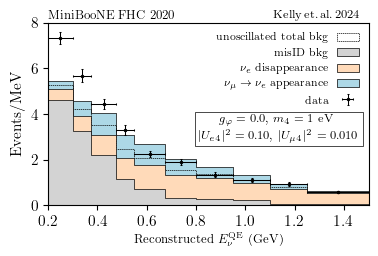

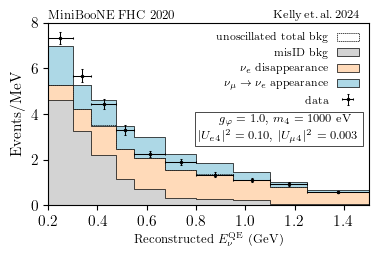

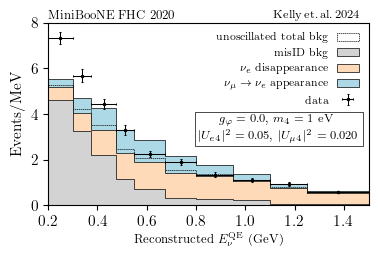

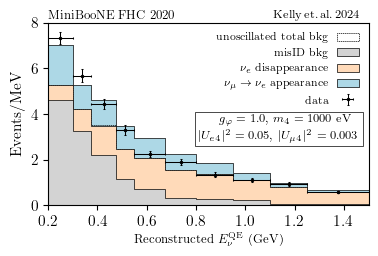

In [7]:
make_rate_plot(rates_dic_osc_BEST, params_BEST_osc, '3+1_osc_BEST')
make_rate_plot(rates_dic_decay_BEST, params_BEST_dec, '3+1_dec_BEST')

make_rate_plot(rates_dic_osc_solar, params_solar_osc, '3+1_osc_solar')
make_rate_plot(rates_dic_decay_solar, params_solar_dec, '3+1_dec_solar')

In [ ]:
micro_nominal_template=get_micro_templates(np.array([ mbfit.mb_nue_analysis_data -  mbfit.mb_nue_analysis_predicted_background]))
plot_tools.step_plot(ax2,
              x=cern.BinEdge[:-1],
              y=micro_nominal_template+cern.BkgVec*STACKED,
              color='black',  lw=1.5,
              label=r"nominal")

plot_tools.step_plot(ax2,
              x=cern.BinEdge[:-1],
              y=np.clip(mub_template_worst, 0, np.inf)+cern.BkgVec*STACKED,
              color=TEMP1_COLOR,  lw=1.5,
              label=r"template 1")

plot_tools.step_plot(ax2,
              x=cern.BinEdge[:-1],
              y=np.clip(mub_template_best, 0, np.inf)+cern.BkgVec*STACKED,
              color=TEMP2_COLOR,  lw=1.5,
              label=r"template 2")


plot_tools.step_plot(ax2, 
              x=cern.BinEdge[:-1],
              y=(np.append(0,converter.miniToMicro(mbfit.mb_sterile_best_fit))+cern.BkgVec*STACKED),
              color='black',
              dashes=(1,1),
              label=r'3+1 best-fit')



[]

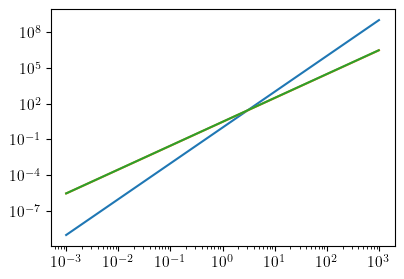

In [18]:
x = np.geomspace(1e-3, 1e3, 1000)
y = x**3

dy_dx = np.gradient(y, x)
dy_dx_2 = np.diff(y)/np.diff(x)

plt.plot(x,y)
plt.plot(x,dy_dx)
plt.plot(x[:-1],dy_dx_2)

plt.loglog()